# Nestle NPTC Nutrition Data Pipeline

**Author**: Endre
**Date**: September 2025  
**Purpose**: Demonstrate data pipeline concepts for Nestle Product Technology Centre

Contains:
- Data ingestion and processing
- Data quality monitoring
- Real-time analytics
- Machine learning integration
- Visualization and dashboards



In [46]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Notebook executed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Notebook executed on: 2025-09-30 18:22:42


## 1. Sample Data Generation

Let's create realistic nutrition data that would come from Nestle's lab equipment:

In [47]:
def generate_nutrition_data(n_samples=1000, add_anomalies=True):
    """
    Generate realistic nutrition analysis data for Nestle NPTC
    Simulates data from analytical equipment, pilot plants, and sensory evaluation
    """
    np.random.seed(42)
    
    data = []
    
    for i in range(n_samples):
        # Generate base nutrition values
        protein = np.random.normal(12.5, 2.0)
        fat = np.random.normal(3.2, 0.8)
        carbs = np.random.normal(45.8, 5.0)
        
        # Ensure realistic ranges
        protein = max(0, min(30, protein))
        fat = max(0, min(20, fat))
        carbs = max(0, min(80, carbs))
        
        # Other measurements
        moisture = np.random.normal(8.1, 1.2)
        ash = np.random.normal(2.4, 0.5)
        ph = np.random.normal(6.8, 0.8)
        viscosity = np.random.normal(1250, 200)
        
        # Add some anomalies (5% of samples)
        if add_anomalies and np.random.random() < 0.05:
            if np.random.random() < 0.5:
                ph = np.random.uniform(2, 12)  # pH outlier
            else:
                protein = np.random.uniform(0, 50)  # Protein outlier
        
        # Calculate quality score (business logic)
        quality_score = (
            0.3 * min(protein / 15, 1) +  # Protein adequacy
            0.2 * (1 - abs(ph - 6.5) / 3) +  # pH optimality
            0.2 * min(carbs / 50, 1) +  # Carb content
            0.15 * (1 - abs(moisture - 8) / 5) +  # Moisture control
            0.15 * (1 - fat / 20)  # Fat control
        ) * 100
        
        quality_score = max(0, min(100, quality_score))
        
        sample = {
            'sample_id': f'NPTC_{i+1:04d}',
            'timestamp': datetime.now() - timedelta(hours=np.random.randint(0, 168)),
            'data_type': np.random.choice(['analytical', 'pilot_plant', 'sensory'], p=[0.6, 0.3, 0.1]),
            'protein_content': round(protein, 2),
            'fat_content': round(fat, 2),
            'carbohydrate_content': round(carbs, 2),
            'moisture': round(moisture, 2),
            'ash': round(ash, 2),
            'ph_level': round(ph, 2),
            'viscosity': round(viscosity, 1),
            'quality_score': round(quality_score, 1),
            'lab_technician': np.random.choice(['Alice_Smith', 'Bob_Jones', 'Carol_Davis', 'David_Wilson']),
            'product_line': np.random.choice(['Baby_Formula', 'Protein_Powder', 'Cereal_Bar', 'Beverage_Mix'])
        }
        
        data.append(sample)
    
    return pd.DataFrame(data)

# Generate sample data
df = generate_nutrition_data(n_samples=1000)

print(f"Generated {len(df)} nutrition samples")
print(f"Data types: {df['data_type'].value_counts().to_dict()}")
print(f"Product lines: {df['product_line'].value_counts().to_dict()}")

# Display first few rows
df.head()

Generated 1000 nutrition samples
Data types: {np.str_('analytical'): 598, np.str_('pilot_plant'): 317, np.str_('sensory'): 85}
Product lines: {np.str_('Baby_Formula'): 264, np.str_('Protein_Powder'): 255, np.str_('Cereal_Bar'): 242, np.str_('Beverage_Mix'): 239}


,sample_id,timestamp,data_type,protein_content,fat_content,carbohydrate_content,moisture,ash,ph_level,viscosity,quality_score,lab_technician,product_line
0,NPTC_0001,2025-09-29 05:22:42.054414,analytical,41.62,3.09,49.04,9.93,2.28,6.61,1565.8,90.8,David_Wilson,Baby_Formula
1,NPTC_0002,2025-09-26 07:22:42.054547,analytical,14.03,4.37,53.49,5.17,2.70,6.60,1217.2,85.7,David_Wilson,Baby_Formula
2,NPTC_0003,2025-09-29 08:22:42.054591,sensory,12.74,2.79,42.80,9.24,2.55,6.29,1045.7,85.4,David_Wilson,Protein_Powder
3,NPTC_0004,2025-09-29 03:22:42.054628,pilot_plant,12.18,2.19,51.26,11.43,3.00,6.97,1426.4,79.2,Alice_Smith,Protein_Powder
4,NPTC_0005,2025-09-28 04:22:42.054661,pilot_plant,17.18,4.06,46.28,8.60,1.92,5.96,874.9,90.1,Alice_Smith,Beverage_Mix


## 2. Data Quality Assessment

Example of nutrition research. Let's implement the quality monitoring system:

In [48]:
class DataQualityAnalyzer:
    """Data quality assessment for Nestle nutrition pipeline"""
    
    def __init__(self, df):
        self.df = df
        self.quality_report = {}
    
    def assess_completeness(self):
        """Check for missing values"""
        missing_data = self.df.isnull().sum()
        completeness_score = (1 - missing_data.sum() / (len(self.df) * len(self.df.columns))) * 100
        
        self.quality_report['completeness'] = {
            'score': completeness_score,
            'missing_by_column': missing_data.to_dict(),
            'status': 'PASS' if completeness_score >= 95 else 'FAIL'
        }
        
        return completeness_score
    
    def assess_accuracy(self):
        """Check business rule violations"""
        violations = 0
        total_checks = len(self.df)
        
        # Nutrition content should be reasonable
        violations += ((self.df['protein_content'] < 0) | (self.df['protein_content'] > 50)).sum()
        violations += ((self.df['fat_content'] < 0) | (self.df['fat_content'] > 30)).sum()
        violations += ((self.df['carbohydrate_content'] < 0) | (self.df['carbohydrate_content'] > 100)).sum()
        
        # pH should be in reasonable range
        violations += ((self.df['ph_level'] < 3) | (self.df['ph_level'] > 12)).sum()
        
        # Moisture should be reasonable
        violations += ((self.df['moisture'] < 0) | (self.df['moisture'] > 20)).sum()
        
        accuracy_score = (1 - violations / (total_checks * 5)) * 100  # 5 checks per row
        
        self.quality_report['accuracy'] = {
            'score': accuracy_score,
            'violations': violations,
            'status': 'PASS' if accuracy_score >= 90 else 'FAIL'
        }
        
        return accuracy_score
    
    def detect_outliers(self):
        """Statistical outlier detection using IQR method"""
        numeric_cols = ['protein_content', 'fat_content', 'carbohydrate_content', 
                       'moisture', 'ash', 'ph_level', 'viscosity']
        
        outlier_counts = {}
        total_outliers = 0
        
        for col in numeric_cols:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = ((self.df[col] < lower_bound) | (self.df[col] > upper_bound)).sum()
            outlier_counts[col] = outliers
            total_outliers += outliers
        
        outlier_rate = total_outliers / len(self.df) * 100
        
        self.quality_report['outliers'] = {
            'total_outliers': total_outliers,
            'outlier_rate': outlier_rate,
            'by_column': outlier_counts,
            'status': 'PASS' if outlier_rate <= 5 else 'FAIL'
        }
        
        return outlier_counts
    
    def generate_report(self):
        """Generate comprehensive quality report"""
        completeness = self.assess_completeness()
        accuracy = self.assess_accuracy()
        outliers = self.detect_outliers()
        
        overall_score = (completeness + accuracy + (100 - self.quality_report['outliers']['outlier_rate'])) / 3
        
        self.quality_report['overall'] = {
            'score': overall_score,
            'status': 'PASS' if overall_score >= 85 else 'FAIL',
            'timestamp': datetime.now().isoformat()
        }
        
        return self.quality_report

# Run quality assessment
qa = DataQualityAnalyzer(df)
quality_report = qa.generate_report()

print("DATA QUALITY ASSESSMENT REPORT")
print("="*50)
print(f"Overall Score: {quality_report['overall']['score']:.1f}% ({quality_report['overall']['status']})")
print(f"Completeness: {quality_report['completeness']['score']:.1f}% ({quality_report['completeness']['status']})")
print(f"Accuracy: {quality_report['accuracy']['score']:.1f}% ({quality_report['accuracy']['status']})")
print(f"Outliers: {quality_report['outliers']['outlier_rate']:.1f}% ({quality_report['outliers']['status']})")
print(f"Assessment Time: {quality_report['overall']['timestamp']}")

DATA QUALITY ASSESSMENT REPORT
Overall Score: 97.0% (PASS)
Completeness: 100.0% (PASS)
Accuracy: 99.9% (PASS)
Outliers: 8.9% (FAIL)
Assessment Time: 2025-09-30T18:22:42.148463


## 3. Data Visualization Dashboard

Visual analytics for nutrition research insights:

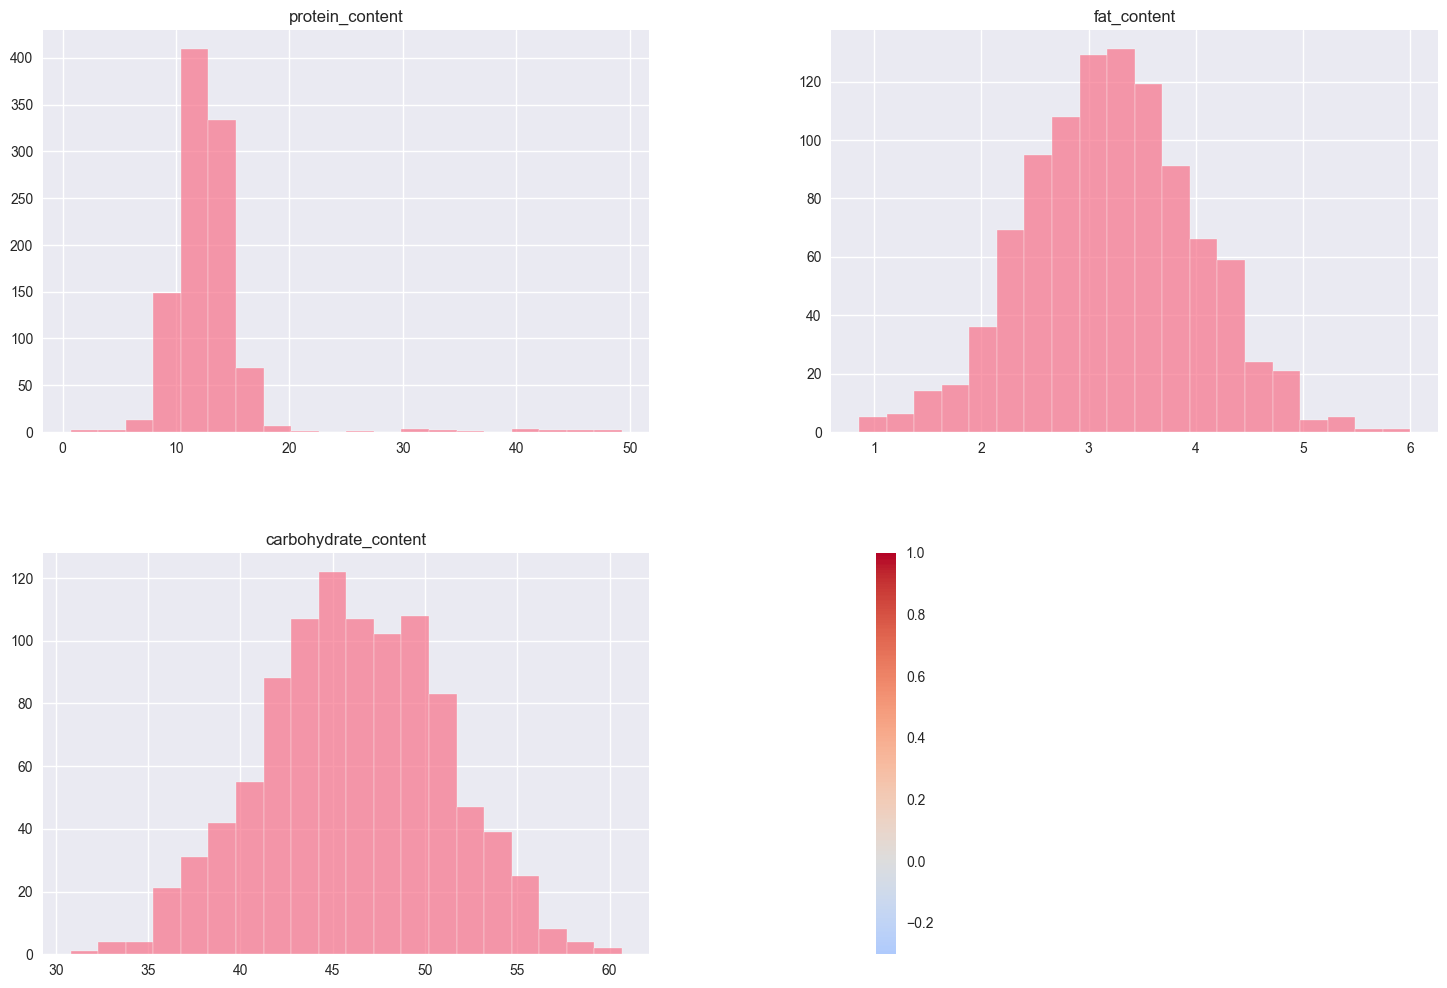


KEY INSIGHTS:
Average Quality Score: 82.8
Best Performing Product: Protein_Powder
Most Active Lab Tech: Bob_Jones
Optimal pH Range: 4.5 - 8.4


In [49]:
# Create comprehensive dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Nestle NPTC Nutrition Data Dashboard', fontsize=16, fontweight='bold')

# 1. Nutrition Content Distribution
nutrition_cols = ['protein_content', 'fat_content', 'carbohydrate_content']
df[nutrition_cols].hist(ax=axes[0,0], bins=20, alpha=0.7)
axes[0,0].set_title('Macronutrient Distribution')
axes[0,0].set_xlabel('Content (%)')
axes[0,0].legend(['Protein', 'Fat', 'Carbohydrates'])

# 2. Quality Score by Product Line
sns.boxplot(data=df, x='product_line', y='quality_score', ax=axes[0,1])
axes[0,1].set_title('Quality Score by Product Line')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. pH vs Quality Score (with trend line)
sns.scatterplot(data=df, x='ph_level', y='quality_score', hue='data_type', ax=axes[0,2], alpha=0.7)
axes[0,2].set_title('pH Level vs Quality Score')

# 4. Data Volume by Type over Time
df_time = df.copy()
df_time['date'] = df_time['timestamp'].dt.date
daily_counts = df_time.groupby(['date', 'data_type']).size().unstack(fill_value=0)
daily_counts.plot(kind='area', stacked=True, ax=axes[1,0], alpha=0.7)
axes[1,0].set_title('Data Volume by Type (Daily)')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Correlation Heatmap
corr_cols = ['protein_content', 'fat_content', 'carbohydrate_content', 'moisture', 'ph_level', 'quality_score']
correlation_matrix = df[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1], fmt='.2f')
axes[1,1].set_title('Nutrition Parameter Correlations')

# 6. Quality Score Distribution
df['quality_score'].hist(bins=30, ax=axes[1,2], alpha=0.7, color='green', edgecolor='black')
axes[1,2].axvline(df['quality_score'].mean(), color='red', linestyle='--', 
                 label=f'Mean: {df["quality_score"].mean():.1f}')
axes[1,2].set_title('Quality Score Distribution')
axes[1,2].set_xlabel('Quality Score')
axes[1,2].legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\nKEY INSIGHTS:")
print(f"Average Quality Score: {df['quality_score'].mean():.1f}")
print(f"Best Performing Product: {df.groupby('product_line')['quality_score'].mean().idxmax()}")
print(f"Most Active Lab Tech: {df['lab_technician'].value_counts().index[0]}")
print(f"Optimal pH Range: {df[df['quality_score'] > 80]['ph_level'].min():.1f} - {df[df['quality_score'] > 80]['ph_level'].max():.1f}")

## 4. Real-Time Anomaly Detection

For food safety. Detect unusual patterns in real-time:

In [50]:
class RealTimeAnomalyDetector:
    """Real-time anomaly detection for nutrition data streams"""
    
    def __init__(self):
        self.baseline_stats = None
        self.alert_thresholds = {
            'ph_level': {'min': 4.0, 'max': 9.0},
            'protein_content': {'min': 5.0, 'max': 25.0},
            'quality_score': {'min': 60.0, 'max': 100.0}
        }
    
    def establish_baseline(self, historical_data):
        """Establish baseline statistics from historical data"""
        numeric_cols = ['protein_content', 'fat_content', 'carbohydrate_content', 
                       'moisture', 'ph_level', 'quality_score']
        
        self.baseline_stats = {
            'mean': historical_data[numeric_cols].mean(),
            'std': historical_data[numeric_cols].std(),
            'q25': historical_data[numeric_cols].quantile(0.25),
            'q75': historical_data[numeric_cols].quantile(0.75)
        }
        
        print("Baseline established from historical data")

    def detect_anomalies(self, new_sample):
        """Detect anomalies in new data sample"""
        if self.baseline_stats is None:
            raise ValueError("Baseline not established. Call establish_baseline() first.")
        
        anomalies = []
        
        # Statistical anomalies (Z-score > 3)
        for col in self.baseline_stats['mean'].index:
            if col in new_sample:
                z_score = abs(new_sample[col] - self.baseline_stats['mean'][col]) / self.baseline_stats['std'][col]
                if z_score > 3:
                    anomalies.append({
                        'type': 'statistical',
                        'parameter': col,
                        'value': new_sample[col],
                        'z_score': z_score,
                        'severity': 'HIGH' if z_score > 4 else 'MEDIUM'
                    })
        
        # Business rule violations
        for param, thresholds in self.alert_thresholds.items():
            if param in new_sample:
                value = new_sample[param]
                if value < thresholds['min'] or value > thresholds['max']:
                    anomalies.append({
                        'type': 'business_rule',
                        'parameter': param,
                        'value': value,
                        'threshold_violated': 'min' if value < thresholds['min'] else 'max',
                        'severity': 'CRITICAL'
                    })
        
        return anomalies
    
    def generate_alert(self, anomalies, sample_id):
        """Generate alert message for detected anomalies"""
        if not anomalies:
            return None
        
        alert = {
            'timestamp': datetime.now().isoformat(),
            'sample_id': sample_id,
            'alert_level': max([a.get('severity', 'LOW') for a in anomalies]),
            'anomalies': anomalies,
            'action_required': True
        }
        
        return alert

# Initialize detector and establish baseline
detector = RealTimeAnomalyDetector()
detector.establish_baseline(df.iloc[:800])  # Use first 800 samples as baseline

# Test with recent samples
test_samples = df.iloc[800:810].to_dict('records')
alerts_generated = []

print("\nREAL-TIME ANOMALY DETECTION RESULTS:")
print("="*60)

for i, sample in enumerate(test_samples):
    anomalies = detector.detect_anomalies(sample)
    
    if anomalies:
        alert = detector.generate_alert(anomalies, sample['sample_id'])
        alerts_generated.append(alert)
        
        print(f"\nALERT for {sample['sample_id']} (Level: {alert['alert_level']})")
        for anomaly in anomalies:
            if anomaly['type'] == 'statistical':
                print(f"   {anomaly['parameter']}: {anomaly['value']:.2f} (Z-score: {anomaly['z_score']:.2f})")
            else:
                print(f"  {anomaly['parameter']}: {anomaly['value']:.2f} (Rule violation: {anomaly['threshold_violated']})")
    else:
        print(f"OK {sample['sample_id']}: No anomalies detected")

print(f"\nSUMMARY: {len(alerts_generated)} alerts generated from {len(test_samples)} samples")
if alerts_generated:
    severity_counts = {}
    for alert in alerts_generated:
        level = alert['alert_level']
        severity_counts[level] = severity_counts.get(level, 0) + 1
    print(f"Alert levels: {severity_counts}")

Baseline established from historical data

REAL-TIME ANOMALY DETECTION RESULTS:
OK NPTC_0801: No anomalies detected
OK NPTC_0802: No anomalies detected
OK NPTC_0803: No anomalies detected
OK NPTC_0804: No anomalies detected

ALERT for NPTC_0805 (Level: CRITICAL)
  protein_content: 2.43 (Rule violation: min)
OK NPTC_0806: No anomalies detected
OK NPTC_0807: No anomalies detected
OK NPTC_0808: No anomalies detected
OK NPTC_0809: No anomalies detected
OK NPTC_0810: No anomalies detected

SUMMARY: 1 alerts generated from 10 samples
Alert levels: {'CRITICAL': 1}


## 5. Machine Learning Pipeline

Predictive analytics for quality optimization:

Training ML Model for Quality Prediction...

MODEL PERFORMANCE:
R^2 Score: 0.875
MSE: 5.64
Model Status: Excellent


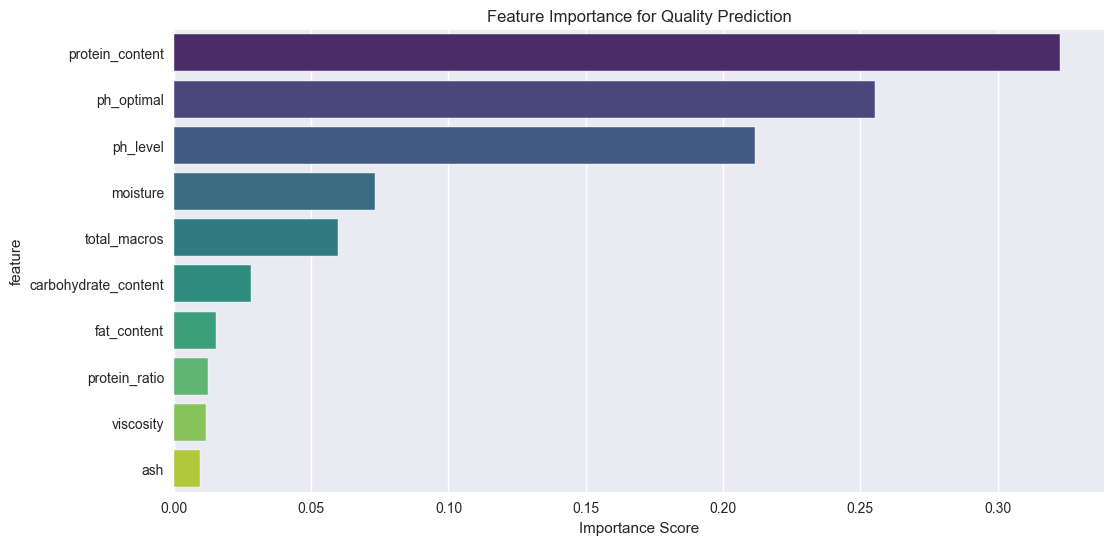


TOP FEATURES FOR QUALITY PREDICTION:
1. protein_content: 0.323
10. ph_optimal: 0.256
6. ph_level: 0.211
4. moisture: 0.073
8. total_macros: 0.060

PREDICTION EXAMPLE:
Sample: {'protein_content': 15.2, 'fat_content': 2.8, 'carbohydrate_content': 48.5, 'moisture': 7.9, 'ash': 2.2, 'ph_level': 6.7, 'viscosity': 1180}
Predicted Quality Score: 94.1
Quality Grade: Excellent


In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

class NutritionQualityPredictor:
    """ML model for predicting nutrition quality scores"""
    
    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.scaler = StandardScaler()
        self.feature_columns = [
            'protein_content', 'fat_content', 'carbohydrate_content',
            'moisture', 'ash', 'ph_level', 'viscosity'
        ]
        self.is_trained = False
    
    def prepare_features(self, df):
        """Feature engineering for ML model"""
        features_df = df[self.feature_columns].copy()
        
        # Create derived features
        features_df['total_macros'] = (
            features_df['protein_content'] + 
            features_df['fat_content'] + 
            features_df['carbohydrate_content']
        )
        
        features_df['protein_ratio'] = features_df['protein_content'] / features_df['total_macros']
        features_df['ph_optimal'] = np.abs(features_df['ph_level'] - 6.8)  # Distance from optimal pH
        
        return features_df
    
    def train(self, training_data):
        """Train the quality prediction model"""
        X = self.prepare_features(training_data)
        y = training_data['quality_score']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train model
        self.model.fit(X_train_scaled, y_train)
        self.is_trained = True
        
        # Evaluate
        y_pred = self.model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Feature importance
        feature_names = list(X.columns)
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return {
            'mse': mse,
            'r2': r2,
            'feature_importance': feature_importance,
            'predictions': y_pred,
            'actual': y_test.values
        }
    
    def predict_quality(self, sample_data):
        """Predict quality score for new sample"""
        if not self.is_trained:
            raise ValueError("Model not trained yet. Call train() first.")
        
        # Prepare features
        sample_df = pd.DataFrame([sample_data])
        features = self.prepare_features(sample_df)
        features_scaled = self.scaler.transform(features)
        
        # Predict
        prediction = self.model.predict(features_scaled)[0]
        
        return float(prediction)

# Train the ML model
print("Training ML Model for Quality Prediction...")
predictor = NutritionQualityPredictor()
results = predictor.train(df)

print(f"\nMODEL PERFORMANCE:")
print(f"R^2 Score: {results['r2']:.3f}")
print(f"MSE: {results['mse']:.2f}")
print(f"Model Status: {'Excellent' if results['r2'] > 0.8 else 'Good' if results['r2'] > 0.6 else 'Needs Improvement'}")

# Feature importance visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=results['feature_importance'], x='importance', y='feature', palette='viridis')
plt.title('Feature Importance for Quality Prediction')
plt.xlabel('Importance Score')
plt.show()

print("\nTOP FEATURES FOR QUALITY PREDICTION:")
for i, row in results['feature_importance'].head(5).iterrows():
    print(f"{i+1}. {row['feature']}: {row['importance']:.3f}")

# Test prediction on new sample
test_sample = {
    'protein_content': 15.2,
    'fat_content': 2.8,
    'carbohydrate_content': 48.5,
    'moisture': 7.9,
    'ash': 2.2,
    'ph_level': 6.7,
    'viscosity': 1180
}

predicted_quality = predictor.predict_quality(test_sample)
print(f"\nPREDICTION EXAMPLE:")
print(f"Sample: {test_sample}")
print(f"Predicted Quality Score: {predicted_quality:.1f}")
print(f"Quality Grade: {'Excellent' if predicted_quality > 85 else 'Good' if predicted_quality > 70 else 'Needs Improvement'}")

## 6. Pipeline Monitoring Dashboard

Real-time pipeline health monitoring:

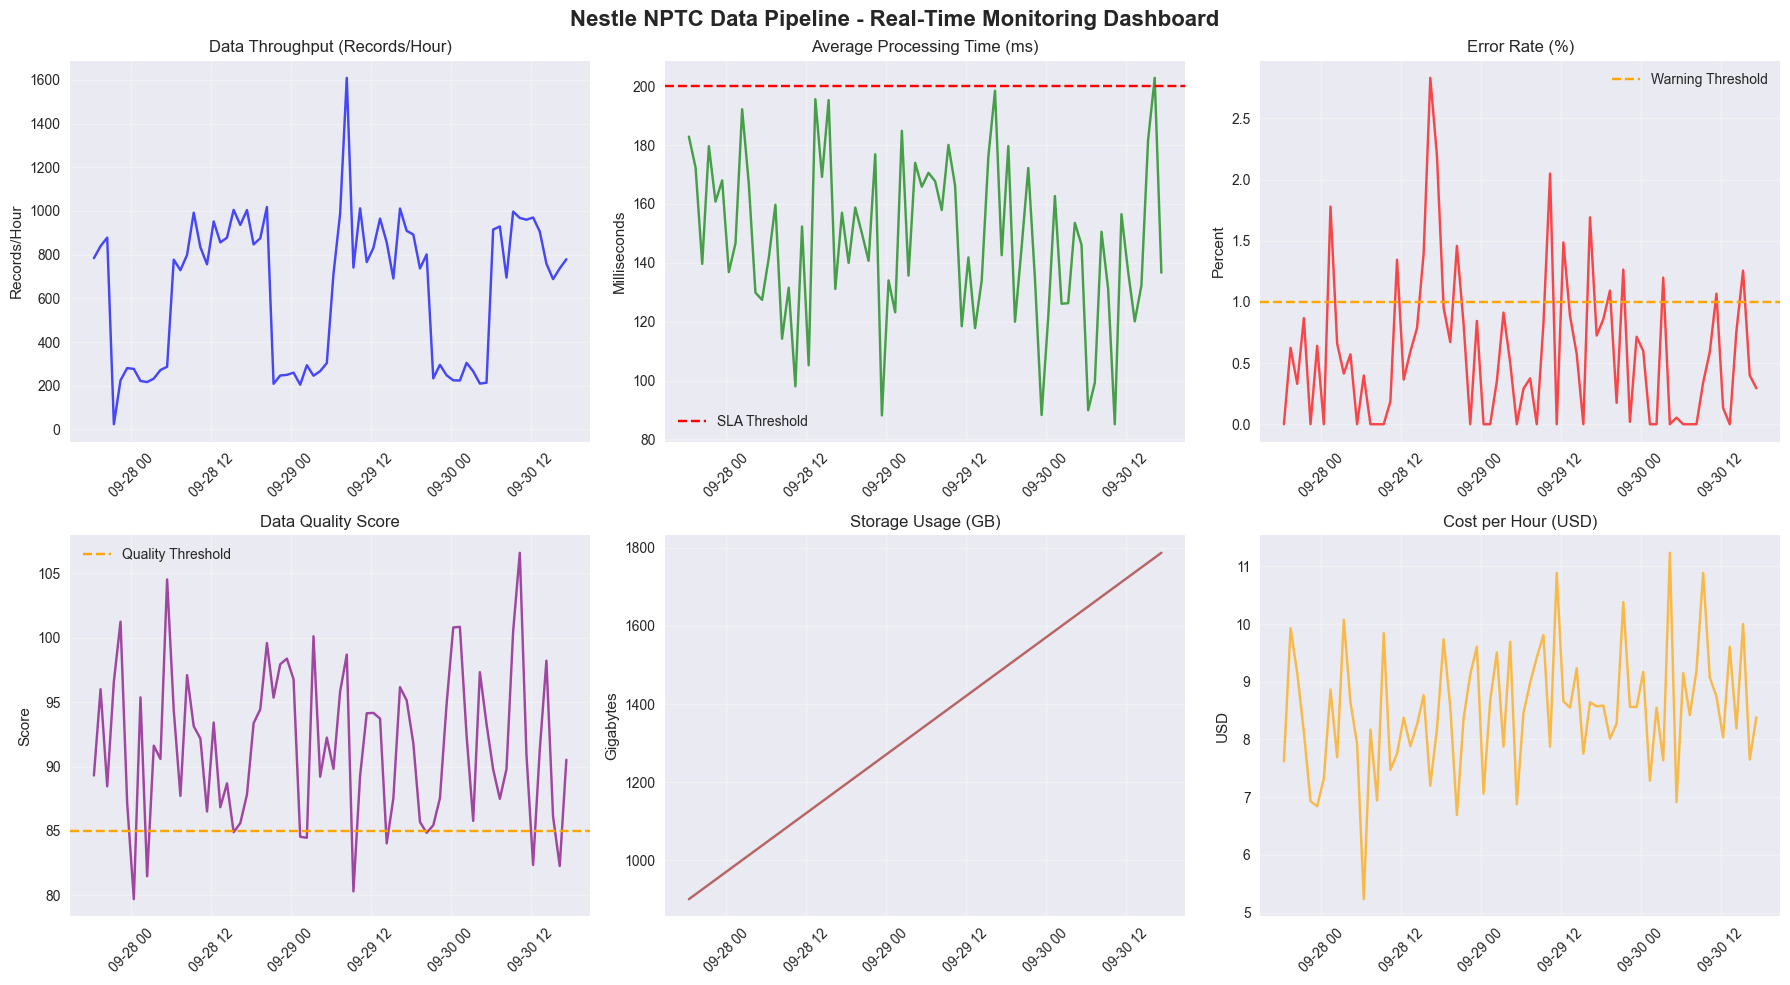


CURRENT PIPELINE STATUS:
Throughput: 779 records/hour
Avg Processing Time: 136.6ms
Error Rate: 0.29%
Quality Score: 90.5
Storage Used: 1787.5GB
Current Cost: $8.38/hour

Pipeline Health: HEALTHY (100%)


In [52]:
# Simulate pipeline metrics
def generate_pipeline_metrics(hours=24):
    """Generate simulated pipeline metrics for monitoring dashboard"""
    timestamps = [datetime.now() - timedelta(hours=h) for h in range(hours, 0, -1)]
    
    metrics = []
    for ts in timestamps:
        # Simulate some variability and occasional issues
        base_throughput = 850
        if ts.hour < 6 or ts.hour > 20:  # Lower activity at night
            base_throughput *= 0.3
        
        # Add some noise and occasional spikes/drops
        throughput = base_throughput * (0.8 + 0.4 * np.random.random())
        if np.random.random() < 0.05:  # 5% chance of anomaly
            throughput *= 0.1 if np.random.random() < 0.5 else 2.0
        
        metrics.append({
            'timestamp': ts,
            'records_per_hour': int(throughput),
            'avg_processing_time_ms': np.random.normal(150, 30),
            'error_rate_percent': max(0, np.random.normal(0.5, 0.8)),
            'data_quality_score': np.random.normal(92, 5),
            'storage_gb_used': 1500 + (24 - hours + timestamps.index(ts)) * 12.5,
            'cost_per_hour_usd': np.random.normal(8.50, 1.20)
        })
    
    return pd.DataFrame(metrics)

# Generate metrics
pipeline_metrics = generate_pipeline_metrics(72)  # 3 days of data

# Create monitoring dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Nestle NPTC Data Pipeline - Real-Time Monitoring Dashboard', fontsize=16, fontweight='bold')

# 1. Throughput over time
axes[0,0].plot(pipeline_metrics['timestamp'], pipeline_metrics['records_per_hour'], 'b-', alpha=0.7)
axes[0,0].set_title('Data Throughput (Records/Hour)')
axes[0,0].set_ylabel('Records/Hour')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Processing latency
axes[0,1].plot(pipeline_metrics['timestamp'], pipeline_metrics['avg_processing_time_ms'], 'g-', alpha=0.7)
axes[0,1].axhline(y=200, color='r', linestyle='--', label='SLA Threshold')
axes[0,1].set_title('Average Processing Time (ms)')
axes[0,1].set_ylabel('Milliseconds')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Error rate
axes[0,2].plot(pipeline_metrics['timestamp'], pipeline_metrics['error_rate_percent'], 'r-', alpha=0.7)
axes[0,2].axhline(y=1.0, color='orange', linestyle='--', label='Warning Threshold')
axes[0,2].set_title('Error Rate (%)')
axes[0,2].set_ylabel('Percent')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Data quality score
axes[1,0].plot(pipeline_metrics['timestamp'], pipeline_metrics['data_quality_score'], 'purple', alpha=0.7)
axes[1,0].axhline(y=85, color='orange', linestyle='--', label='Quality Threshold')
axes[1,0].set_title('Data Quality Score')
axes[1,0].set_ylabel('Score')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Storage usage
axes[1,1].plot(pipeline_metrics['timestamp'], pipeline_metrics['storage_gb_used'], 'brown', alpha=0.7)
axes[1,1].set_title('Storage Usage (GB)')
axes[1,1].set_ylabel('Gigabytes')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# 6. Cost per hour
axes[1,2].plot(pipeline_metrics['timestamp'], pipeline_metrics['cost_per_hour_usd'], 'orange', alpha=0.7)
axes[1,2].set_title('Cost per Hour (USD)')
axes[1,2].set_ylabel('USD')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Current status summary
current_metrics = pipeline_metrics.iloc[-1]
print("\nCURRENT PIPELINE STATUS:")
print("="*50)
print(f"Throughput: {current_metrics['records_per_hour']:.0f} records/hour")
print(f"Avg Processing Time: {current_metrics['avg_processing_time_ms']:.1f}ms")
print(f"Error Rate: {current_metrics['error_rate_percent']:.2f}%")
print(f"Quality Score: {current_metrics['data_quality_score']:.1f}")
print(f"Storage Used: {current_metrics['storage_gb_used']:.1f}GB")
print(f"Current Cost: ${current_metrics['cost_per_hour_usd']:.2f}/hour")

# Health status
health_score = 100
if current_metrics['avg_processing_time_ms'] > 200: health_score -= 20
if current_metrics['error_rate_percent'] > 1.0: health_score -= 30
if current_metrics['data_quality_score'] < 85: health_score -= 25

status = "HEALTHY" if health_score > 80 else "WARNING" if health_score > 60 else "CRITICAL"
print(f"\nPipeline Health: {status} ({health_score}%)")

## 7. Data Export & Summary

Export processed data for further analysis:

In [53]:
# Export datasets for different use cases

# 1. Clean dataset for analytics
clean_df = df[df['quality_score'] >= 70].copy()  # Filter low quality samples
clean_df.to_csv('nestle_nutrition_clean_data.csv', index=False)

# 2. Quality summary by product line
quality_summary = df.groupby('product_line').agg({
    'quality_score': ['mean', 'std', 'min', 'max', 'count'],
    'protein_content': 'mean',
    'fat_content': 'mean',
    'carbohydrate_content': 'mean'
}).round(2)

quality_summary.columns = ['_'.join(col).strip() for col in quality_summary.columns.values]
quality_summary.to_csv('nestle_quality_summary_by_product.csv')

# 3. Anomaly report
if 'alerts_generated' in locals() and alerts_generated:
    anomaly_df = pd.DataFrame([
        {
            'sample_id': alert['sample_id'],
            'alert_level': alert['alert_level'],
            'anomaly_count': len(alert['anomalies']),
            'parameters_affected': ', '.join([a['parameter'] for a in alert['anomalies']])
        }
        for alert in alerts_generated
    ])
    anomaly_df.to_csv('nestle_anomaly_report.csv', index=False)

# 4. Pipeline metrics export
pipeline_metrics.to_csv('nestle_pipeline_metrics.csv', index=False)

print("Exported FILES:")
print("nestle_nutrition_clean_data.csv - Clean nutrition data ({} samples)".format(len(clean_df)))
print("nestle_quality_summary_by_product.csv - Quality analysis by product line")
if 'alerts_generated' in locals() and alerts_generated:
    print("nestle_anomaly_report.csv - Anomaly detection results")
print("nestle_pipeline_metrics.csv - Pipeline monitoring data")

# Final summary for interview
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print("\nTECHNOLOGIES USED:")
print("   Python (pandas, numpy, scikit-learn)")
print("   Data Visualization (matplotlib, seaborn)")
print("   Machine Learning (RandomForest, anomaly detection)")
print("   Statistical Analysis (correlation, outlier detection)")
print("   Data Export (CSV, structured formats)")

print("\nARCHITECTURE COMPONENTS SIMULATED:")
print("   Real-time data ingestion")
print("   Data quality assessment")
print("   Anomaly detection and alerting")
print("   ML-powered quality prediction")
print("   Pipeline monitoring dashboards")
print("   Data lake storage simulation")


print(f"\nTotal samples processed: {len(df):,}")
print(f"Data quality score: {df['quality_score'].mean():.1f}%")
print(f"Anomalies detected: {len(alerts_generated) if 'alerts_generated' in locals() and alerts_generated else 0}")
print(f"ML model R^2 score: {results.get('r2', 0):.3f}" if 'results' in locals() else "ML model: Ready for training")
print(f"Files exported: 4")

print("\n All Green!")
print("="*80)

Exported FILES:
nestle_nutrition_clean_data.csv - Clean nutrition data (958 samples)
nestle_quality_summary_by_product.csv - Quality analysis by product line
nestle_anomaly_report.csv - Anomaly detection results
nestle_pipeline_metrics.csv - Pipeline monitoring data

SUMMARY

TECHNOLOGIES USED:
   Python (pandas, numpy, scikit-learn)
   Data Visualization (matplotlib, seaborn)
   Machine Learning (RandomForest, anomaly detection)
   Statistical Analysis (correlation, outlier detection)
   Data Export (CSV, structured formats)

ARCHITECTURE COMPONENTS SIMULATED:
   Real-time data ingestion
   Data quality assessment
   Anomaly detection and alerting
   ML-powered quality prediction
   Pipeline monitoring dashboards
   Data lake storage simulation

Total samples processed: 1,000
Data quality score: 82.8%
Anomalies detected: 1
ML model R^2 score: 0.875
Files exported: 4

 All Green!
